# League Betting Platform – KDA Prediction Model
This notebook predicts KDA for players in live League of Legends games using champion-specific stats and game context.
-  Model: XGBoost
-  Backend ready: Works with API integration
-  Customize: Input your Riot API key abnd account information


In [144]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import requests
import json
import math
import time
import re
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import pickle



INSERT YOUR API key and region

In [146]:
api_key = "INSERT YOUR API KEY"
REGION = "americas"

TO Customize just enter ur username in leagueNames

Example input = Persons Name, Username, Tagline

In [5]:

versions_url = "https://ddragon.leagueoflegends.com/api/versions.json"
latest_version = requests.get(versions_url).json()[0]
leagueNames = [["Danny", "Somesort", "DOPA"]]



nameToPuuid = {}
for names in leagueNames:
    GAME_NAME = names[1]
    TAG_LINE  = names[2]
    api_url = f"https://{REGION}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{GAME_NAME}/{TAG_LINE}?api_key={api_key}"
    resp = requests.get(api_url)
    player_info = resp.json()
    nameToPuuid[names[0]] = player_info["puuid"]


nameToPuuid


{'Danny': 'XZOWlCTKfBAR4NTWMrHJas52SfM-UX5dYjV-KxsDJ3i98w1BUF_wikfXOTWttK26q_rgWMg6gaOs_Q'}

In [6]:
champ_data_url = "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/champion-summary.json"
champ_data = requests.get(champ_data_url).json()
champ_id_to_name = {champ["id"]: champ["name"] for champ in champ_data if champ["id"] != -1}


Retrieve match history  

Replace "Danny" with your friends name

In [7]:
puuid = nameToPuuid["Danny"]
puuid

games_to_fetch = 2000
counter_per_req = 100

all_match_ids = []
start = 0
requests_made = 0
num_requests_needed = math.ceil(games_to_fetch / counter_per_req)

for i in range(num_requests_needed):
    start = i * counter_per_req

    api_url = f"https://{REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start={start}&count={counter_per_req}&api_key={api_key}"

    print(f"Requesting games {start} to {start + counter_per_req - 1}...")

    try:
        response = requests.get(api_url)
        requests_made += 1

        if response.status_code == 200:
            match_ids_batch = response.json()

            if not match_ids_batch:
                print("No more match IDs found. Stopping.")
                break

            all_match_ids.extend(match_ids_batch)
            print(f"Successfully fetched {len(match_ids_batch)} IDs.")


            if len(all_match_ids) >= games_to_fetch:
                print(f"Reached target of {games_to_fetch} games.")
                all_match_ids = all_match_ids[:games_to_fetch]
                break

        elif response.status_code == 404:
             print(f"Error 404: Data not found (Maybe PUUID or Region is incorrect, or no games at index {start}?). Stopping.")
             break
        elif response.status_code == 429:
            print("Error 429: Rate limit exceeded. Waiting and might retry or stop (implement retry logic if needed).")
            time.sleep(120)
            break
        else:
            print(f"Error: Received status code {response.status_code}")
            print(f"Response: {response.text}")
            break

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the request: {e}")
        break

    if i < num_requests_needed - 1:
         print("Waiting for rate limit...")
         time.sleep(1.2)


print("\nFetching Complete")
print(f"Total requests made: {requests_made}")
print(f"Total match IDs collected: {len(all_match_ids)}")


Requesting games 0 to 99...
Successfully fetched 100 IDs.
Waiting for rate limit...
Requesting games 100 to 199...
Successfully fetched 100 IDs.
Waiting for rate limit...
Requesting games 200 to 299...
Successfully fetched 100 IDs.
Waiting for rate limit...
Requesting games 300 to 399...
Successfully fetched 100 IDs.
Waiting for rate limit...
Requesting games 400 to 499...
Successfully fetched 100 IDs.
Waiting for rate limit...
Requesting games 500 to 599...
Successfully fetched 100 IDs.
Waiting for rate limit...
Requesting games 600 to 699...
Successfully fetched 100 IDs.
Waiting for rate limit...
Requesting games 700 to 799...
Successfully fetched 78 IDs.
Waiting for rate limit...
Requesting games 800 to 899...
No more match IDs found. Stopping.

Fetching Complete
Total requests made: 9
Total match IDs collected: 778


double check it worked

In [10]:
print(all_match_ids[:5])

['NA1_5294037290', 'NA1_5294000739', 'NA1_5289478224', 'NA1_5289438533', 'NA1_5289413717']


cleans match history so it gets 5v5 only

will take a while due to api rate limits

In [14]:
validGames = []
processed_count = 0
total_matches_to_check = len(all_match_ids)
ARAM_QUEUE_ID = 450

print("Starting")

for matchId in all_match_ids:
    match_url = f"https://{REGION}.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}"

    try:
        response = requests.get(match_url)
        processed_count += 1

        print(f"Processing game {processed_count}/{total_matches_to_check}. Waiting for rate limit...")
        time.sleep(1.2)

        # Check if the request was successful
        if response.status_code == 200:
            match_data = response.json()
            game_info = match_data.get('info', {})
            queue_id = game_info.get('queueId')

            # Check if the queueId is NOT ARAM
            if queue_id != ARAM_QUEUE_ID:
                validGames.append(matchId)
            else:
                 pass

        elif response.status_code == 404:
             print(f"Warning: Match {matchId} not found (Error 404). Skipping.")
             continue # Skip to the next matchId
        elif response.status_code == 429:
            print(f"Error 429: Rate limit exceeded during match lookup for {matchId}. Stopping.")
            print("You may need to wait and resume processing later.")
            break
        else:
            print(f"Error fetching match {matchId}: Status code {response.status_code}. Skipping.")
            print(f"Response: {response.text}")
            continue

    except requests.exceptions.RequestException as e:
        print(f"Network error processing match {matchId}: {e}. Skipping.")
        processed_count += 1
        continue

    except Exception as e:
        print(f"An unexpected error occurred processing match {matchId}: {e}. Skipping.")
        processed_count += 1
        continue


print("\nFiltering Complete")
print(f"Total matches checked: {processed_count}")
print(f"Total matches after cleaning: {len(validGames)}")
# print("First 10 valid Match IDs:", validGames[:10]) # Optional


Starting
Processing game 1/778. Waiting for rate limit...
Processing game 2/778. Waiting for rate limit...
Processing game 3/778. Waiting for rate limit...
Processing game 4/778. Waiting for rate limit...
Processing game 5/778. Waiting for rate limit...
Processing game 6/778. Waiting for rate limit...
Processing game 7/778. Waiting for rate limit...
Processing game 8/778. Waiting for rate limit...
Processing game 9/778. Waiting for rate limit...
Processing game 10/778. Waiting for rate limit...
Processing game 11/778. Waiting for rate limit...
Processing game 12/778. Waiting for rate limit...
Processing game 13/778. Waiting for rate limit...
Processing game 14/778. Waiting for rate limit...
Processing game 15/778. Waiting for rate limit...
Processing game 16/778. Waiting for rate limit...
Processing game 17/778. Waiting for rate limit...
Processing game 18/778. Waiting for rate limit...
Processing game 19/778. Waiting for rate limit...
Processing game 20/778. Waiting for rate limit...


Save/ load just so you dont need to redu if you refreshed

In [15]:
# Save to file
with open("valid_matches.json", "w") as f:
    json.dump(validGames, f)

# Later, load from file
# with open("valid_matches.json", "r") as f:
#    validGames = json.load(f)


Init Dataframe

In [17]:
columns = ['gameId', 'gamePatch', 'friendChampionId', 'role', 'friendRank',
           'enemyLaneChampId', 'enemyLaneRank', 'enemyWinRate',
           'hist_avg_K_on_champ', 'hist_avg_D_on_champ', 'hist_avg_A_on_champ',
           'hist_GamesPlayed_on_champ', 'hist_WinRate_on_champ',
           'kills', 'deaths', 'assists']

df = pd.DataFrame(columns=columns)

FILL in dataframe


In [18]:

# RANk to ELO #
RANK_TO_ELO_BASE = {
    "IRON IV": 600, "IRON III": 650, "IRON II": 700, "IRON I": 750,
    "BRONZE IV": 800, "BRONZE III": 850, "BRONZE II": 900, "BRONZE I": 950,
    "SILVER IV": 1000, "SILVER III": 1075, "SILVER II": 1150, "SILVER I": 1225,
    "GOLD IV": 1300, "GOLD III": 1375, "GOLD II": 1450, "GOLD I": 1525,
    "PLATINUM IV": 1600, "PLATINUM III": 1675, "PLATINUM II": 1750, "PLATINUM I": 1825,
    "EMERALD IV": 1900, "EMERALD III": 1975, "EMERALD II": 2050, "EMERALD I": 2125,
    "DIAMOND IV": 2200, "DIAMOND III": 2300, "DIAMOND II": 2400, "DIAMOND I": 2500,
    "DEFAULT_ELO": 1200
}

# Define rank order for comparison
RANK_ORDER = {
    "IRON": 1, "BRONZE": 2, "SILVER": 3, "GOLD": 4, "PLATINUM": 5, "EMERALD": 6, "DIAMOND": 7,
    "MASTER": 8, "GRANDMASTER": 9, "CHALLENGER": 10
}

# Define division order for comparison
DIVISION_ORDER = {"IV": 1, "III": 2, "II": 3, "I": 4}

MASTER_PLUS_BASE_ELO = 2600

# Function to get Elo from rank string
def get_elo(rank_string):
    rank_upper = rank_string.upper().strip()
    master_plus_match = re.match(r"^(MASTER|GRANDMASTER|CHALLENGER)\s*(\d+)\s*LP$", rank_upper)

    if master_plus_match:
        lp = int(master_plus_match.group(2))
        calculated_elo = MASTER_PLUS_BASE_ELO + lp
        return calculated_elo
    else:
        if rank_upper in ["IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "EMERALD", "DIAMOND"]:
             rank_upper = f"{rank_upper} IV"
        return RANK_TO_ELO_BASE.get(rank_upper, RANK_TO_ELO_BASE["DEFAULT_ELO"])

# Function to get win rate from rank info
def get_winrate(rank_info):
    for entry in rank_info:
        if entry.get("queueType") == "RANKED_SOLO_5x5":
            wins = entry.get("wins", 0)
            losses = entry.get("losses", 0)
            total = wins + losses
            if total > 0:
                return round(wins / total, 2)
            else:
                return 0
    return 0

# Dictionary to store rank and win rate information (to avoid repeated API calls)
player_data_cache = {}

# Function to get player rank and win rate
def get_player_data(puuid, region, api_key):
    if puuid in player_data_cache:
        return player_data_cache[puuid]

    rank_url = f"https://na1.api.riotgames.com/lol/league/v4/entries/by-puuid/{puuid}?api_key={api_key}"
    try:
        rank_response = requests.get(rank_url)
        rank_response.raise_for_status()
        rank_info = rank_response.json()

        # Get pretty rank string
        rank = get_pretty_rank(rank_info)

        # Calculate Elo based on rank
        elo = get_elo(rank)

        # Get win rate
        win_rate = get_winrate(rank_info)

        # Cache the data
        player_data = {"rank": rank, "elo": elo, "winRate": win_rate}
        player_data_cache[puuid] = player_data

        return player_data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching ranked data: {e}")
        return {"rank": "Unranked", "elo": RANK_TO_ELO_BASE["DEFAULT_ELO"], "winRate": 0}

# Function to get pretty rank from rank info
def get_pretty_rank(rank_info):
    soloq_rank = None
    flex_rank = None

    for entry in rank_info:
        if entry.get("queueType") == "RANKED_SOLO_5x5":
            tier = entry.get('tier')
            lp = entry.get('leaguePoints')
            if tier in ["MASTER", "GRANDMASTER", "CHALLENGER"]:
                soloq_rank = f"{tier.title()} {lp} LP"
            else:
                soloq_rank = f"{tier.title()} {entry.get('rank')}"
        elif entry.get("queueType") == "RANKED_FLEX_SR":
            tier = entry.get('tier')
            lp = entry.get('leaguePoints')
            if tier in ["MASTER", "GRANDMASTER", "CHALLENGER"]:
                flex_rank = f"{tier.title()} {lp} LP"
            else:
                flex_rank = f"{tier.title()} {entry.get('rank')}"

    # Compare ranks and return the higher one
    if soloq_rank and flex_rank:
        return compare_ranks(soloq_rank, flex_rank)
    elif soloq_rank:
        return soloq_rank
    elif flex_rank:
        return flex_rank
    else:
        return "Unranked"

# Function to compare ranks
def compare_ranks(rank1, rank2):
    if not rank1:
        return rank2
    if not rank2:
        return rank1

    # Parse Master+ ranks
    master1_match = re.match(r"^(Master|Grandmaster|Challenger)\s*(\d+)\s*LP$", rank1, re.IGNORECASE)
    master2_match = re.match(r"^(Master|Grandmaster|Challenger)\s*(\d+)\s*LP$", rank2, re.IGNORECASE)

    # If both are Master+
    if master1_match and master2_match:
        tier1 = master1_match.group(1).upper()
        tier2 = master2_match.group(1).upper()

        if RANK_ORDER[tier1] != RANK_ORDER[tier2]:
            return rank1 if RANK_ORDER[tier1] > RANK_ORDER[tier2] else rank2

        # Same tier, compare LP
        lp1 = int(master1_match.group(2))
        lp2 = int(master2_match.group(2))
        return rank1 if lp1 >= lp2 else rank2

    # If only one is Master+
    elif master1_match:
        return rank1
    elif master2_match:
        return rank2

    # For regular ranks
    try:
        parts1 = rank1.split()
        parts2 = rank2.split()

        tier1 = parts1[0].upper()
        tier2 = parts2[0].upper()

        if RANK_ORDER[tier1] != RANK_ORDER[tier2]:
            return rank1 if RANK_ORDER[tier1] > RANK_ORDER[tier2] else rank2

        # Same tier, compare division
        div1 = parts1[1]
        div2 = parts2[1]

        return rank1 if DIVISION_ORDER[div1] >= DIVISION_ORDER[div2] else rank2
    except (IndexError, KeyError):
        # If there's an error parsing, return the first rank
        return rank1

# Main data collection loop
processed_count = 0
total_matches_to_process = len(validGames)

print(f"Starting data collection for {total_matches_to_process} valid games")

for matchId in validGames:
    match_url = f"https://{REGION}.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}"
    processed_count += 1
    print(f"Fetching game {processed_count}/{total_matches_to_process}: {matchId}")

    try:
        response = requests.get(match_url)

        print("Waiting for rate limit...")
        time.sleep(1.2)

        if response.status_code == 200:
            match_data = response.json()
            info = match_data.get('info', {})
            participants = info.get('participants', [])

            friend_participant = None
            opponent_participant = None
            friend_role = "UNKNOWN"

            # Find the player's data
            for p in participants:
                if p.get('puuid') == puuid:
                    friend_participant = p
                    friend_role = p.get('teamPosition') or p.get('individualPosition', 'UNKNOWN')
                    break

            if not friend_participant:
                print(f"  Friend PUUID not found in match {matchId}. Skipping.")
                continue

            # Find opponent in the same role
            for p in participants:
                if (p.get('puuid') != puuid and
                    (p.get('teamPosition') == friend_role or p.get('individualPosition') == friend_role) and
                    friend_role != 'UNKNOWN' and
                    p.get('teamId') != friend_participant.get('teamId')):
                    opponent_participant = p
                    break

            if not opponent_participant:
                print(f"  Could not find opponent for role {friend_role} in match {matchId}. Using default values.")

            # Get friend's champion ID
            friend_champion_id = friend_participant.get('championId', 0)

            # Get friend's rank, Elo, and win rate
            friend_data = get_player_data(puuid, REGION, api_key)
            friend_rank = friend_data["rank"]
            friend_elo = friend_data["elo"]

            # Get opponent's champion ID, rank, Elo, and win rate
            enemy_champion_id = 0
            enemy_rank = "Unranked"
            enemy_elo = RANK_TO_ELO_BASE["DEFAULT_ELO"]
            enemy_win_rate = 0

            if opponent_participant:
                enemy_champion_id = opponent_participant.get('championId', 0)
                if opponent_participant.get('puuid'):
                    enemy_data = get_player_data(opponent_participant.get('puuid'), REGION, api_key)
                    enemy_rank = enemy_data["rank"]
                    enemy_elo = enemy_data["elo"]
                    enemy_win_rate = enemy_data["winRate"]

            # Get raw performance stats for this game
            kills = friend_participant.get('kills', 0)
            deaths = friend_participant.get('deaths', 0)
            assists = friend_participant.get('assists', 0)

            # Create a new row as a dictionary
            new_row = {
                'gameId': matchId,
                'gamePatch': info.get('gameVersion', '').split('.')[0] + '.' + info.get('gameVersion', '').split('.')[1],
                'friendChampionId': friend_champion_id,
                'role': friend_role,
                'friendRank': friend_rank,
                'friendElo': friend_elo,
                'enemyLaneChampId': enemy_champion_id,
                'enemyLaneRank': enemy_rank,
                'enemyLaneElo': enemy_elo,
                'hist_avg_K_on_champ': 0,
                'hist_avg_D_on_champ': 0,
                'hist_avg_A_on_champ': 0,
                'hist_GamesPlayed_on_champ': 0,
                'hist_WinRate_on_champ': 0,
                'enemyWinRate': enemy_win_rate,
                'kills': kills,
                'deaths': deaths,
                'assists': assists
            }

            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        else:
            print(f"  Error fetching match {matchId}: Status {response.status_code}. Skipping.")
            if response.status_code == 429:
                print("  Rate limit hit hard. Waiting longer...")
                time.sleep(120)  # Wait 2 minutes if rate limit hit

    except requests.exceptions.RequestException as e:
        print(f"  Network error fetching match {matchId}: {e}. Skipping.")
        continue
    except Exception as e:
        print(f"  Unexpected error processing match {matchId}: {e}. Skipping.")
        continue

print("\nData Collection Complete")

# Print summary
print(f"Collected data for {len(df)} games")
print(df.head())

Starting data collection for 768 valid games
Fetching game 1/768: NA1_5294037290
Waiting for rate limit...


<ipython-input-18-016e6ecb0906>:262: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


Fetching game 2/768: NA1_5294000739
Waiting for rate limit...
Fetching game 3/768: NA1_5289478224
Waiting for rate limit...
Fetching game 4/768: NA1_5289438533
Waiting for rate limit...
Fetching game 5/768: NA1_5289413717
Waiting for rate limit...
Fetching game 6/768: NA1_5284649552
Waiting for rate limit...
Fetching game 7/768: NA1_5279997312
Waiting for rate limit...
Fetching game 8/768: NA1_5279975391
Waiting for rate limit...
Fetching game 9/768: NA1_5278762839
Waiting for rate limit...
Fetching game 10/768: NA1_5270231127
Waiting for rate limit...
Fetching game 11/768: NA1_5270207948
Waiting for rate limit...
Fetching game 12/768: NA1_5269488280
Waiting for rate limit...
Fetching game 13/768: NA1_5269465859
Waiting for rate limit...
Fetching game 14/768: NA1_5269435217
Waiting for rate limit...
Fetching game 15/768: NA1_5269403016
Waiting for rate limit...
Fetching game 16/768: NA1_5268080124
Waiting for rate limit...
Fetching game 17/768: NA1_5268066118
Waiting for rate limit...


In [19]:
df.head()

,gameId,gamePatch,friendChampionId,role,friendRank,enemyLaneChampId,enemyLaneRank,enemyWinRate,hist_avg_K_on_champ,hist_avg_D_on_champ,hist_avg_A_on_champ,hist_GamesPlayed_on_champ,hist_WinRate_on_champ,kills,deaths,assists,friendElo,enemyLaneElo
0,NA1_5294037290,15.10,112,MIDDLE,Emerald I,893,Master 95 LP,0.60,0,0,0,0,0,8,5,19,2125.0,2695.0
1,NA1_5294000739,15.10,4,MIDDLE,Emerald I,238,Master 53 LP,0.53,0,0,0,0,0,6,5,3,2125.0,2653.0
2,NA1_5289478224,15.10,236,BOTTOM,Emerald I,81,Emerald I,0.33,0,0,0,0,0,6,12,2,2125.0,2125.0
3,NA1_5289438533,15.10,517,MIDDLE,Emerald I,800,Diamond II,0.51,0,0,0,0,0,20,19,8,2125.0,2400.0
4,NA1_5289413717,15.10,3,MIDDLE,Emerald I,82,Diamond III,0.29,0,0,0,0,0,5,7,5,2125.0,2300.0


Save current Df just in case

In [ ]:
df.to_csv('cleaned.csv', index=False)

In [77]:
df = df[df['role'] != 'Invalid']


In [75]:
df = pd.read_csv('danny.csv')


In [78]:
df.shape[0]

751

In [79]:
# First, check what columns we actually have
print(df.columns.tolist())

df.loc[:, 'has_winrate'] = (~df['enemyWinRate'].isna() & (df['enemyWinRate'] > 0)).astype(int)

mean_winrate = df.loc[df['enemyWinRate'] > 0, 'enemyWinRate'].mean()
if pd.isna(mean_winrate):
    mean_winrate = 0.5

# Fill missing values with the mean
df.loc[:, 'enemyWinRate'] = df['enemyWinRate'].fillna(mean_winrate)
df.loc[df['enemyWinRate'] < 0, 'enemyWinRate'] = mean_winrate

# Check if we have 'enemyLaneRank' instead of 'enemyRank'
if 'enemyLaneRank' in df.columns:
    df.loc[:, 'is_ranked'] = (df['enemyLaneRank'] != 'Unranked').astype(int)

    df.loc[:, 'enemyRankNumeric'] = df['enemyLaneRank'].fillna('Unranked')
    df.loc[df['enemyRankNumeric'] == 'Unranked', 'enemyRankNumeric'] = -1

df.drop(['friendRank', 'enemyLaneRank', 'enemyRankNumeric'], axis=1, inplace=True)
df['role'] = df['role'].replace('UTILITY', 'SUPPORT')
df.drop(['hist_GamesPlayed_on_champ','hist_WinRate_on_champ'], axis=1, inplace=True)


['gameId', 'gamePatch', 'friendChampionId', 'role', 'friendRank', 'enemyLaneChampId', 'enemyLaneRank', 'enemyWinRate', 'hist_avg_K_on_champ', 'hist_avg_D_on_champ', 'hist_avg_A_on_champ', 'hist_GamesPlayed_on_champ', 'hist_WinRate_on_champ', 'kills', 'deaths', 'assists', 'friendElo', 'enemyLaneElo']


In [80]:
df

,gameId,gamePatch,friendChampionId,role,enemyLaneChampId,enemyWinRate,hist_avg_K_on_champ,hist_avg_D_on_champ,hist_avg_A_on_champ,kills,deaths,assists,friendElo,enemyLaneElo,has_winrate,is_ranked
0,NA1_5294037290,15.10,112,MIDDLE,893,0.60,0,0,0,8,5,19,2125.0,2695.0,1,1
1,NA1_5294000739,15.10,4,MIDDLE,238,0.53,0,0,0,6,5,3,2125.0,2653.0,1,1
2,NA1_5289478224,15.10,236,BOTTOM,81,0.33,0,0,0,6,12,2,2125.0,2125.0,1,1
3,NA1_5289438533,15.10,517,MIDDLE,800,0.51,0,0,0,20,19,8,2125.0,2400.0,1,1
4,NA1_5289413717,15.10,3,MIDDLE,82,0.29,0,0,0,5,7,5,2125.0,2300.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,NA1_4680793444,13.11,202,BOTTOM,360,0.44,0,0,0,8,7,13,2125.0,2125.0,1,1
764,NA1_4678584082,13.11,112,MIDDLE,238,0.65,0,0,0,1,5,4,2125.0,2200.0,1,1
765,NA1_4678510729,13.11,61,MIDDLE,45,0.57,0,0,0,10,6,11,2125.0,1525.0,1,1
766,NA1_4678480195,13.11,112,MIDDLE,4,0.59,0,0,0,9,3,7,2125.0,2300.0,1,1


In [59]:
df.to_csv('cleaned.csv', index=False)

mickey mouse way to get the avg hist of kda

In [81]:
import pandas as pd
import numpy as np

def fill_historical_kda(df):
    # Make a copy to avoid modifying the original
    result_df = df.copy()

    # Get original indices in reverse order (from bottom to top)
    indices = result_df.index.tolist()
    indices.reverse()  # Reverse so we go from bottom (oldest) to top (newest)

    # Initialize tracking dictionaries for each champion's running stats
    champ_stats = {}

    # Process each game chronologically from oldest to newest
    for idx in indices:
        row = result_df.loc[idx]
        champ_id = row['friendChampionId']

        # Initialize champion stats if first encounter
        if champ_id not in champ_stats:
            champ_stats[champ_id] = {
                'games': 0,
                'total_kills': 0,
                'total_deaths': 0,
                'total_assists': 0
            }

        # Calculate historical averages based on PREVIOUS games only
        if champ_stats[champ_id]['games'] > 0:
            # Round to integers as per your dataset structure
            result_df.at[idx, 'hist_avg_K_on_champ'] = round(champ_stats[champ_id]['total_kills'] / champ_stats[champ_id]['games'])
            result_df.at[idx, 'hist_avg_D_on_champ'] = round(champ_stats[champ_id]['total_deaths'] / champ_stats[champ_id]['games'])
            result_df.at[idx, 'hist_avg_A_on_champ'] = round(champ_stats[champ_id]['total_assists'] / champ_stats[champ_id]['games'])
            result_df.at[idx, 'has_hist'] = 1  # Mark that historical data was available
        else:
            # For first time playing a champion, set historical averages to 0
            result_df.at[idx, 'hist_avg_K_on_champ'] = 0
            result_df.at[idx, 'hist_avg_D_on_champ'] = 0
            result_df.at[idx, 'hist_avg_A_on_champ'] = 0
            result_df.at[idx, 'has_hist'] = 0  # Mark that no historical data was available

        # Update the champion's stats with current game data
        # Handle potential NaN values
        kills = 0 if pd.isna(row['kills']) else row['kills']
        deaths = 0 if pd.isna(row['deaths']) else row['deaths']
        assists = 0 if pd.isna(row['assists']) else row['assists']

        champ_stats[champ_id]['games'] += 1
        champ_stats[champ_id]['total_kills'] += kills
        champ_stats[champ_id]['total_deaths'] += deaths
        champ_stats[champ_id]['total_assists'] += assists

    # Ensure columns are integer type
    result_df['hist_avg_K_on_champ'] = result_df['hist_avg_K_on_champ'].astype(int)
    result_df['hist_avg_D_on_champ'] = result_df['hist_avg_D_on_champ'].astype(int)
    result_df['hist_avg_A_on_champ'] = result_df['hist_avg_A_on_champ'].astype(int)
    result_df['has_hist'] = result_df['has_hist'].astype(int)

    return result_df


In [82]:
df = fill_historical_kda(df)


In [83]:
df.head()

,gameId,gamePatch,friendChampionId,role,enemyLaneChampId,enemyWinRate,hist_avg_K_on_champ,hist_avg_D_on_champ,hist_avg_A_on_champ,kills,deaths,assists,friendElo,enemyLaneElo,has_winrate,is_ranked,has_hist
0,NA1_5294037290,15.1,112,MIDDLE,893,0.60,6,5,6,8,5,19,2125.0,2695.0,1,1,1
1,NA1_5294000739,15.1,4,MIDDLE,238,0.53,5,4,8,6,5,3,2125.0,2653.0,1,1,1
2,NA1_5289478224,15.1,236,BOTTOM,81,0.33,11,8,6,6,12,2,2125.0,2125.0,1,1,1
3,NA1_5289438533,15.1,517,MIDDLE,800,0.51,4,11,12,20,19,8,2125.0,2400.0,1,1,1
4,NA1_5289413717,15.1,3,MIDDLE,82,0.29,5,4,14,5,7,5,2125.0,2300.0,1,1,1


In [84]:
champ_role_map = {
    266: 'Fighter', 103: 'Mage', 84: 'Assassin', 166: 'Marksman', 12: 'Tank',
    799: 'Fighter', 32: 'Tank', 34: 'Mage', 1: 'Mage', 523: 'Marksman',
    22: 'Marksman', 136: 'Mage', 893: 'Mage', 268: 'Mage', 432: 'Support',
    200: 'Fighter', 53: 'Tank', 63: 'Mage', 201: 'Tank', 233: 'Fighter',
    51: 'Marksman', 164: 'Fighter', 69: 'Mage', 31: 'Tank', 42: 'Marksman',
    122: 'Fighter', 131: 'Fighter', 119: 'Marksman', 36: 'Tank', 245: 'Assassin',
    60: 'Assassin', 28: 'Assassin', 81: 'Marksman', 9: 'Mage', 114: 'Fighter',
    105: 'Assassin', 3: 'Tank', 41: 'Fighter', 86: 'Fighter', 150: 'Fighter',
    79: 'Fighter', 104: 'Marksman', 887: 'Fighter', 120: 'Fighter', 74: 'Mage',
    910: 'Mage', 420: 'Fighter', 39: 'Fighter', 427: 'Support', 40: 'Support',
    59: 'Fighter', 24: 'Fighter', 126: 'Marksman', 202: 'Marksman', 222: 'Marksman',
    145: 'Marksman', 429: 'Marksman', 43: 'Mage', 30: 'Mage', 38: 'Assassin',
    55: 'Assassin', 10: 'Mage', 141: 'Fighter', 85: 'Mage', 121: 'Assassin',
    203: 'Marksman', 240: 'Fighter', 96: 'Marksman', 897: 'Tank', 7: 'Assassin',
    64: 'Fighter', 89: 'Tank', 876: 'Fighter', 127: 'Mage', 236: 'Marksman',
    117: 'Support', 99: 'Mage', 54: 'Tank', 90: 'Mage', 57: 'Tank',
    11: 'Assassin', 800: 'Mage', 902: 'Support', 21: 'Marksman', 62: 'Fighter',
    82: 'Fighter', 25: 'Mage', 950: 'Assassin', 267: 'Support', 75: 'Fighter',
    111: 'Tank', 518: 'Mage', 76: 'Assassin', 895: 'Fighter', 56: 'Fighter',
    20: 'Tank', 2: 'Fighter', 61: 'Mage', 516: 'Tank', 80: 'Fighter',
    78: 'Tank', 555: 'Support', 246: 'Assassin', 133: 'Marksman', 497: 'Support',
    33: 'Tank', 421: 'Fighter', 526: 'Tank', 888: 'Support', 58: 'Fighter',
    107: 'Assassin', 92: 'Fighter', 68: 'Fighter', 13: 'Mage', 360: 'Marksman',
    113: 'Tank', 235: 'Support', 147: 'Support', 875: 'Fighter', 35: 'Assassin',
    98: 'Tank', 102: 'Fighter', 27: 'Tank', 14: 'Tank', 15: 'Marksman',
    72: 'Tank', 901: 'Marksman', 37: 'Support', 16: 'Support', 50: 'Mage',
    517: 'Mage', 134: 'Mage', 223: 'Tank', 163: 'Mage', 91: 'Assassin',
    44: 'Support', 17: 'Marksman', 412: 'Support', 18: 'Marksman', 48: 'Fighter',
    23: 'Fighter', 4: 'Mage', 29: 'Marksman', 77: 'Fighter', 6: 'Fighter',
    110: 'Marksman', 67: 'Marksman', 45: 'Mage', 161: 'Mage', 711: 'Mage',
    254: 'Fighter', 234: 'Fighter', 112: 'Mage', 8: 'Mage', 106: 'Fighter',
    19: 'Fighter', 498: 'Marksman', 101: 'Mage', 5: 'Fighter', 157: 'Fighter',
    777: 'Fighter', 83: 'Fighter', 350: 'Support', 154: 'Tank', 238: 'Assassin',
    221: 'Marksman', 115: 'Mage', 26: 'Support', 142: 'Mage', 143: 'Mage'
}
df['champRole'] = df['friendChampionId'].map(champ_role_map).fillna('Other')
df['enemyChampRole'] = df['enemyLaneChampId'].map(champ_role_map).fillna('Other')
df = pd.get_dummies(df, columns=['champRole'])
df = pd.get_dummies(df, columns=['enemyChampRole'])
df = pd.get_dummies(df, columns=['role'])


In [86]:
df.head()

,gameId,gamePatch,friendChampionId,enemyLaneChampId,enemyWinRate,hist_avg_K_on_champ,hist_avg_D_on_champ,hist_avg_A_on_champ,kills,deaths,...,enemyChampRole_Fighter,enemyChampRole_Mage,enemyChampRole_Marksman,enemyChampRole_Support,enemyChampRole_Tank,role_BOTTOM,role_JUNGLE,role_MIDDLE,role_SUPPORT,role_TOP
0,NA1_5294037290,15.1,112,893,0.60,6,5,6,8,5,...,False,True,False,False,False,False,False,True,False,False
1,NA1_5294000739,15.1,4,238,0.53,5,4,8,6,5,...,False,False,False,False,False,False,False,True,False,False
2,NA1_5289478224,15.1,236,81,0.33,11,8,6,6,12,...,False,False,True,False,False,True,False,False,False,False
3,NA1_5289438533,15.1,517,800,0.51,4,11,12,20,19,...,False,True,False,False,False,False,False,True,False,False
4,NA1_5289413717,15.1,3,82,0.29,5,4,14,5,7,...,True,False,False,False,False,False,False,True,False,False


In [66]:
len(champ_role_map)

170

In [87]:
# Assuming df is your DataFrame
df['enemyChampRole_Other'] = 0

In [88]:
y_kills = df['kills']
y_deaths = df['deaths']
y_assists = df['assists']

In [89]:
X = df.drop(columns=['kills', 'deaths', 'assists', 'gameId', 'gamePatch', 'friendChampionId', 'enemyLaneChampId'])


In [90]:
X

,enemyWinRate,hist_avg_K_on_champ,hist_avg_D_on_champ,hist_avg_A_on_champ,friendElo,enemyLaneElo,has_winrate,is_ranked,has_hist,champRole_Assassin,...,enemyChampRole_Mage,enemyChampRole_Marksman,enemyChampRole_Support,enemyChampRole_Tank,role_BOTTOM,role_JUNGLE,role_MIDDLE,role_SUPPORT,role_TOP,enemyChampRole_Other
0,0.60,6,5,6,2125.0,2695.0,1,1,1,False,...,True,False,False,False,False,False,True,False,False,0
1,0.53,5,4,8,2125.0,2653.0,1,1,1,False,...,False,False,False,False,False,False,True,False,False,0
2,0.33,11,8,6,2125.0,2125.0,1,1,1,False,...,False,True,False,False,True,False,False,False,False,0
3,0.51,4,11,12,2125.0,2400.0,1,1,1,False,...,True,False,False,False,False,False,True,False,False,0
4,0.29,5,4,14,2125.0,2300.0,1,1,1,False,...,False,False,False,False,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.44,0,0,0,2125.0,2125.0,1,1,0,False,...,False,True,False,False,True,False,False,False,False,0
764,0.65,9,3,7,2125.0,2200.0,1,1,1,False,...,False,False,False,False,False,False,True,False,False,0
765,0.57,0,0,0,2125.0,1525.0,1,1,0,False,...,True,False,False,False,False,False,True,False,False,0
766,0.59,0,0,0,2125.0,2300.0,1,1,0,False,...,True,False,False,False,False,False,True,False,False,0


In [91]:
X.columns

Index(['enemyWinRate', 'hist_avg_K_on_champ', 'hist_avg_D_on_champ',
       'hist_avg_A_on_champ', 'friendElo', 'enemyLaneElo', 'has_winrate',
       'is_ranked', 'has_hist', 'champRole_Assassin', 'champRole_Fighter',
       'champRole_Mage', 'champRole_Marksman', 'champRole_Support',
       'champRole_Tank', 'enemyChampRole_Assassin', 'enemyChampRole_Fighter',
       'enemyChampRole_Mage', 'enemyChampRole_Marksman',
       'enemyChampRole_Support', 'enemyChampRole_Tank', 'role_BOTTOM',
       'role_JUNGLE', 'role_MIDDLE', 'role_SUPPORT', 'role_TOP',
       'enemyChampRole_Other'],
      dtype='object')

In [94]:
split_idx = int(len(X) * 0.85)


X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()

y_kills_train = y_kills.iloc[:split_idx].copy()
y_kills_test = y_kills.iloc[split_idx:].copy()

y_deaths_train = y_deaths.iloc[:split_idx].copy()
y_deaths_test = y_deaths.iloc[split_idx:].copy()

y_assists_train = y_assists.iloc[:split_idx].copy()
y_assists_test = y_assists.iloc[split_idx:].copy()

X_train['enemyWinRate'] = X_train['enemyWinRate'].astype(float)
X_test['enemyWinRate'] = X_test['enemyWinRate'].astype(float)

In [96]:
kills_xgb = xgb.XGBRegressor(
    objective='count:poisson',
    seed=42,
    eval_metric='mae',
    early_stopping_rounds=10
)
deaths_xgb = xgb.XGBRegressor(
    objective='count:poisson',
    seed=42,
    eval_metric='mae',
    early_stopping_rounds=10
)
assist_xgb = xgb.XGBRegressor(
    objective='count:poisson',
    seed=42,
    eval_metric='mae',
    early_stopping_rounds=10
)

In [113]:
kills_xgb.fit(X_train, y_kills_train, eval_set=[(X_test, y_kills_test)], verbose=True)


[0]	validation_0-mae:7.12415
[1]	validation_0-mae:6.42279
[2]	validation_0-mae:5.86740
[3]	validation_0-mae:5.39949
[4]	validation_0-mae:5.02825
[5]	validation_0-mae:4.71763
[6]	validation_0-mae:4.45747
[7]	validation_0-mae:4.22903
[8]	validation_0-mae:4.03696
[9]	validation_0-mae:3.90542
[10]	validation_0-mae:3.78869
[11]	validation_0-mae:3.69092
[12]	validation_0-mae:3.60652
[13]	validation_0-mae:3.54011
[14]	validation_0-mae:3.49230
[15]	validation_0-mae:3.44304
[16]	validation_0-mae:3.37568
[17]	validation_0-mae:3.35043
[18]	validation_0-mae:3.28245
[19]	validation_0-mae:3.24158
[20]	validation_0-mae:3.22079
[21]	validation_0-mae:3.19997
[22]	validation_0-mae:3.17051
[23]	validation_0-mae:3.14237
[24]	validation_0-mae:3.12932
[25]	validation_0-mae:3.12816
[26]	validation_0-mae:3.12678
[27]	validation_0-mae:3.12642
[28]	validation_0-mae:3.10402
[29]	validation_0-mae:3.09842
[30]	validation_0-mae:3.08400
[31]	validation_0-mae:3.08182
[32]	validation_0-mae:3.06152
[33]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [114]:
print(kills_xgb.get_booster().save_config())


{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"42","seed":"42","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"64"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0.699999988","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch_ratio":"

In [115]:
y_pred_kills = kills_xgb.predict(X_test)
y_pred_deaths = deaths_xgb.predict(X_test)
y_pred_assists = assist_xgb.predict(X_test)


In [116]:
oldmae = skm.mean_absolute_error(y_kills_test, y_pred_kills)
mse = skm.mean_squared_error(y_kills_test, y_pred_kills)
oldrmse = np.sqrt(mse)

print(f'MAE: {oldmae:.3f}')
print(f'RMSE: {oldrmse:.3f}')

MAE: 3.001
RMSE: 3.848


In [117]:
deaths_xgb.fit(X_train, y_deaths_train, eval_set=[(X_test, y_deaths_test)], verbose=True)


[0]	validation_0-mae:4.48364
[1]	validation_0-mae:4.30438
[2]	validation_0-mae:4.05907
[3]	validation_0-mae:3.82741
[4]	validation_0-mae:3.64360
[5]	validation_0-mae:3.50828
[6]	validation_0-mae:3.41423
[7]	validation_0-mae:3.39229
[8]	validation_0-mae:3.39476
[9]	validation_0-mae:3.38696
[10]	validation_0-mae:3.35893
[11]	validation_0-mae:3.30541
[12]	validation_0-mae:3.27360
[13]	validation_0-mae:3.23660
[14]	validation_0-mae:3.21908
[15]	validation_0-mae:3.21632
[16]	validation_0-mae:3.21005
[17]	validation_0-mae:3.21059
[18]	validation_0-mae:3.19675
[19]	validation_0-mae:3.18228
[20]	validation_0-mae:3.17928
[21]	validation_0-mae:3.17784
[22]	validation_0-mae:3.17252
[23]	validation_0-mae:3.17442
[24]	validation_0-mae:3.16815
[25]	validation_0-mae:3.18219
[26]	validation_0-mae:3.17229
[27]	validation_0-mae:3.17941
[28]	validation_0-mae:3.17862
[29]	validation_0-mae:3.18010
[30]	validation_0-mae:3.17166
[31]	validation_0-mae:3.17522
[32]	validation_0-mae:3.17981
[33]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [118]:
print(deaths_xgb.get_booster().save_config())


{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"42","seed":"42","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"35"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0.699999988","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch_ratio":"

In [119]:
mae = skm.mean_absolute_error(y_deaths_test, y_pred_deaths)
mse = skm.mean_squared_error(y_deaths_test, y_pred_deaths)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')

MAE: 3.168
RMSE: 3.808


In [120]:
assist_xgb.fit(X_train, y_assists_train, eval_set=[(X_test, y_assists_test)], verbose=True)


[0]	validation_0-mae:36.41245
[1]	validation_0-mae:31.35612
[2]	validation_0-mae:26.99165
[3]	validation_0-mae:23.20375
[4]	validation_0-mae:19.91487
[5]	validation_0-mae:17.11914
[6]	validation_0-mae:14.73999
[7]	validation_0-mae:12.76057
[8]	validation_0-mae:11.05582
[9]	validation_0-mae:9.53629
[10]	validation_0-mae:8.36399
[11]	validation_0-mae:7.43858
[12]	validation_0-mae:6.70882
[13]	validation_0-mae:6.13540
[14]	validation_0-mae:5.76675
[15]	validation_0-mae:5.40206
[16]	validation_0-mae:5.12524
[17]	validation_0-mae:4.92413
[18]	validation_0-mae:4.77684
[19]	validation_0-mae:4.66962
[20]	validation_0-mae:4.56124
[21]	validation_0-mae:4.47419
[22]	validation_0-mae:4.37340
[23]	validation_0-mae:4.34726
[24]	validation_0-mae:4.32104
[25]	validation_0-mae:4.31138
[26]	validation_0-mae:4.31888
[27]	validation_0-mae:4.30463
[28]	validation_0-mae:4.29570
[29]	validation_0-mae:4.29700
[30]	validation_0-mae:4.29226
[31]	validation_0-mae:4.28053
[32]	validation_0-mae:4.27359
[33]	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [121]:
print(assist_xgb.get_booster().save_config())


{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"42","seed":"42","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"45"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0.699999988","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"uniform","sketch_ratio":"

In [122]:
mae = skm.mean_absolute_error(y_assists_test, y_pred_assists)
mse = skm.mean_squared_error(y_assists_test, y_pred_assists)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')

MAE: 4.237
RMSE: 5.340


In [123]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd

def optimize_xgb_model(X_train, y_train, n_trials=100):
    # Convert any object columns to numeric or category types
    for col in X_train.select_dtypes(['object']).columns:
        try:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
            # Fill NaN values with median
            X_train[col].fillna(X_train[col].median(), inplace=True)
        except:
            # If conversion to numeric fails, try category
            X_train[col] = X_train[col].astype('category')

    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'gamma': trial.suggest_float('gamma', 0.01, 0.5),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
            'max_delta_step': trial.suggest_float('max_delta_step', 0.1, 3.0)
        }

        # Create model with count:poisson objective
        model = xgb.XGBRegressor(
            objective='count:poisson',
            eval_metric='mae',
            seed=42,
            enable_categorical=True,
            **params
        )

        # Use KFold for cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        cv_scores = []
        for train_idx, val_idx in kf.split(X_train):
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Train model (removed early_stopping_rounds parameter)
            model.fit(
                X_fold_train, y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                verbose=False
            )

            # Predict on validation fold
            preds = model.predict(X_fold_val)

            # Calculate MAE
            mae = np.mean(np.abs(preds - y_fold_val))
            cv_scores.append(mae)

        return np.mean(cv_scores)

    # Create study with pruning
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    study = optuna.create_study(direction='minimize', pruner=pruner)

    # Add callback to print progress
    def print_callback(study, trial):
        if trial.number % 10 == 0:
            print(f"Trial {trial.number}: Current MAE = {trial.value}, Best MAE = {study.best_value}")

    # Run optimization
    study.optimize(objective, n_trials=n_trials, callbacks=[print_callback])

    print("\n" + "="*50)
    print(f"Best parameters: {study.best_params}")
    print(f"Best MAE: {study.best_value}")
    print("="*50 + "\n")

    # Return best model with optimized parameters
    best_params = study.best_params
    best_model = xgb.XGBRegressor(
        objective='count:poisson',
        eval_metric='mae',
        seed=42,
        enable_categorical=True,
        **best_params
    )

    # Train the best model on the entire training set
    best_model.fit(X_train, y_train)

    return best_model, best_params

In [124]:
best_kills_model, kills_params = optimize_xgb_model(X_train, y_kills_train)

[I 2025-05-28 01:17:11,588] A new study created in memory with name: no-name-f5c0c31d-cf49-4623-bdd1-ba5df83d89f9
[I 2025-05-28 01:17:12,527] Trial 0 finished with value: 3.4639624628612373 and parameters: {'max_depth': 5, 'learning_rate': 0.011670373841877182, 'n_estimators': 197, 'min_child_weight': 1, 'gamma': 0.30908898051985473, 'subsample': 0.7438331323814295, 'colsample_bytree': 0.9905142123990319, 'reg_lambda': 0.2630205135817161, 'reg_alpha': 0.04722168723391628, 'max_delta_step': 1.0360144454296865}. Best is trial 0 with value: 3.4639624628612373.


Trial 0: Current MAE = 3.4639624628612373, Best MAE = 3.4639624628612373


[I 2025-05-28 01:17:13,229] Trial 1 finished with value: 3.353214731778744 and parameters: {'max_depth': 7, 'learning_rate': 0.1770344653964246, 'n_estimators': 106, 'min_child_weight': 1, 'gamma': 0.4951301940307037, 'subsample': 0.9307510860673964, 'colsample_bytree': 0.6290793035717785, 'reg_lambda': 2.811593036181143, 'reg_alpha': 0.00035083368240589714, 'max_delta_step': 2.210844959770422}. Best is trial 1 with value: 3.353214731778744.
[I 2025-05-28 01:17:13,798] Trial 2 finished with value: 3.3312328236602893 and parameters: {'max_depth': 3, 'learning_rate': 0.15216246231400776, 'n_estimators': 135, 'min_child_weight': 2, 'gamma': 0.4345056818305817, 'subsample': 0.8568235823185246, 'colsample_bytree': 0.9237476608569497, 'reg_lambda': 6.205420250174553, 'reg_alpha': 0.006896564057357407, 'max_delta_step': 2.2414222487473796}. Best is trial 2 with value: 3.3312328236602893.
[I 2025-05-28 01:17:14,245] Trial 3 finished with value: 3.4130830618721526 and parameters: {'max_depth': 

Trial 10: Current MAE = 3.5321949404657005, Best MAE = 3.316479459352146


[I 2025-05-28 01:17:20,627] Trial 11 finished with value: 3.324679896801593 and parameters: {'max_depth': 3, 'learning_rate': 0.18954305939917235, 'n_estimators': 149, 'min_child_weight': 2, 'gamma': 0.38313038510333614, 'subsample': 0.8367013728036831, 'colsample_bytree': 0.6421911602243231, 'reg_lambda': 8.71691273764659, 'reg_alpha': 0.0020813224364313247, 'max_delta_step': 2.87764158481413}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:21,275] Trial 12 finished with value: 3.5682496627924714 and parameters: {'max_depth': 3, 'learning_rate': 0.0860359447866044, 'n_estimators': 166, 'min_child_weight': 4, 'gamma': 0.3554897887856528, 'subsample': 0.804896745177508, 'colsample_bytree': 0.6080265068649171, 'reg_lambda': 1.6394567321788103, 'reg_alpha': 0.0014365072132472303, 'max_delta_step': 2.969033255608008}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:22,024] Trial 13 finished with value: 3.4101759674130228 and parameters: {'max_depth': 

Trial 20: Current MAE = 3.4096123189482044, Best MAE = 3.316479459352146


[I 2025-05-28 01:17:29,865] Trial 21 finished with value: 3.3324273809687943 and parameters: {'max_depth': 3, 'learning_rate': 0.03586370811812683, 'n_estimators': 190, 'min_child_weight': 3, 'gamma': 0.18478136067559914, 'subsample': 0.8926401025659648, 'colsample_bytree': 0.7131589121566225, 'reg_lambda': 9.98373548443114, 'reg_alpha': 1.3560123292501446e-05, 'max_delta_step': 1.3407873404408273}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:30,585] Trial 22 finished with value: 3.3612552701150924 and parameters: {'max_depth': 3, 'learning_rate': 0.029553159192337426, 'n_estimators': 184, 'min_child_weight': 3, 'gamma': 0.1797055082912295, 'subsample': 0.8346550322743453, 'colsample_bytree': 0.6552126293359942, 'reg_lambda': 9.01855864258844, 'reg_alpha': 6.578150778761882e-05, 'max_delta_step': 1.7015329761755722}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:31,313] Trial 23 finished with value: 3.4091219971088442 and parameters: {'max_de

Trial 30: Current MAE = 3.3871094061047073, Best MAE = 3.316479459352146


[I 2025-05-28 01:17:37,154] Trial 31 finished with value: 3.3526690716378567 and parameters: {'max_depth': 3, 'learning_rate': 0.02483915313853622, 'n_estimators': 181, 'min_child_weight': 3, 'gamma': 0.2142538682597281, 'subsample': 0.8475788090406033, 'colsample_bytree': 0.6280799886053136, 'reg_lambda': 8.598613225943057, 'reg_alpha': 0.012349181502625083, 'max_delta_step': 1.5285141119972365}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:37,905] Trial 32 finished with value: 3.3315440655326634 and parameters: {'max_depth': 3, 'learning_rate': 0.0808379200230534, 'n_estimators': 193, 'min_child_weight': 3, 'gamma': 0.14791278024876336, 'subsample': 0.796953354717008, 'colsample_bytree': 0.6649511151864206, 'reg_lambda': 3.119195875987535, 'reg_alpha': 0.0007547058588363235, 'max_delta_step': 1.7240784107350464}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:38,698] Trial 33 finished with value: 3.3189966181513126 and parameters: {'max_depth

Trial 40: Current MAE = 3.7203563721601185, Best MAE = 3.316479459352146


[I 2025-05-28 01:17:45,929] Trial 41 finished with value: 3.587509601774413 and parameters: {'max_depth': 3, 'learning_rate': 0.04902204427083136, 'n_estimators': 110, 'min_child_weight': 2, 'gamma': 0.3935504329495484, 'subsample': 0.8660762442143987, 'colsample_bytree': 0.5392191181944141, 'reg_lambda': 6.460695365089767, 'reg_alpha': 0.0032056115324199134, 'max_delta_step': 2.1714224782250273}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:46,549] Trial 42 finished with value: 3.3842998153346726 and parameters: {'max_depth': 4, 'learning_rate': 0.09977742463693624, 'n_estimators': 125, 'min_child_weight': 2, 'gamma': 0.44268716619933823, 'subsample': 0.8879015208550362, 'colsample_bytree': 0.6395848752847417, 'reg_lambda': 3.552677575987459, 'reg_alpha': 0.053595949264347444, 'max_delta_step': 1.2044198014731107}. Best is trial 7 with value: 3.316479459352146.
[I 2025-05-28 01:17:47,185] Trial 43 finished with value: 4.1444769036934135 and parameters: {'max_dept

Trial 50: Current MAE = 3.3156392173870928, Best MAE = 3.3156392173870928


[I 2025-05-28 01:17:54,613] Trial 51 finished with value: 3.3110901661202545 and parameters: {'max_depth': 3, 'learning_rate': 0.08492597590251857, 'n_estimators': 128, 'min_child_weight': 2, 'gamma': 0.16456187727082489, 'subsample': 0.861956668277966, 'colsample_bytree': 0.5257597287654281, 'reg_lambda': 3.1111707459243547, 'reg_alpha': 0.00033144205970270815, 'max_delta_step': 1.849167224587714}. Best is trial 51 with value: 3.3110901661202545.
[I 2025-05-28 01:17:56,085] Trial 52 finished with value: 3.3119359006973235 and parameters: {'max_depth': 3, 'learning_rate': 0.07869536398220756, 'n_estimators': 127, 'min_child_weight': 2, 'gamma': 0.1242371271576217, 'subsample': 0.8614428997872527, 'colsample_bytree': 0.5009806584971814, 'reg_lambda': 3.9918539885927538, 'reg_alpha': 0.0002364048761600716, 'max_delta_step': 1.7995143681256571}. Best is trial 51 with value: 3.3110901661202545.
[I 2025-05-28 01:17:57,095] Trial 53 finished with value: 3.310085518813626 and parameters: {'ma

Trial 60: Current MAE = 3.3306789700763195, Best MAE = 3.310085518813626


[I 2025-05-28 01:18:06,454] Trial 61 finished with value: 3.307027743372509 and parameters: {'max_depth': 3, 'learning_rate': 0.11172578177033256, 'n_estimators': 132, 'min_child_weight': 5, 'gamma': 0.13048613124344735, 'subsample': 0.8925943582972798, 'colsample_bytree': 0.9682217277918184, 'reg_lambda': 3.3864166831827793, 'reg_alpha': 0.00025669137674753, 'max_delta_step': 2.1223712127081775}. Best is trial 61 with value: 3.307027743372509.
[I 2025-05-28 01:18:07,049] Trial 62 finished with value: 3.308252683251099 and parameters: {'max_depth': 3, 'learning_rate': 0.11372349561580292, 'n_estimators': 130, 'min_child_weight': 5, 'gamma': 0.10353172130107763, 'subsample': 0.8990806369051036, 'colsample_bytree': 0.9926205946902287, 'reg_lambda': 3.5488103365985357, 'reg_alpha': 0.00021130653197702997, 'max_delta_step': 2.1675507827535396}. Best is trial 61 with value: 3.307027743372509.
[I 2025-05-28 01:18:07,659] Trial 63 finished with value: 3.304590171117952 and parameters: {'max_d

Trial 70: Current MAE = 3.313677171890543, Best MAE = 3.304590171117952


[I 2025-05-28 01:18:14,390] Trial 71 finished with value: 3.3058544516871406 and parameters: {'max_depth': 3, 'learning_rate': 0.09983382204916091, 'n_estimators': 141, 'min_child_weight': 5, 'gamma': 0.10334141042952547, 'subsample': 0.8833130623590751, 'colsample_bytree': 0.9849682755310867, 'reg_lambda': 2.697471552909162, 'reg_alpha': 0.00018930030523168421, 'max_delta_step': 2.176746012692916}. Best is trial 63 with value: 3.304590171117952.
[I 2025-05-28 01:18:15,035] Trial 72 finished with value: 3.3068395250777565 and parameters: {'max_depth': 3, 'learning_rate': 0.12817355525880234, 'n_estimators': 146, 'min_child_weight': 5, 'gamma': 0.13821798532855772, 'subsample': 0.8866749104019024, 'colsample_bytree': 0.9860530328462146, 'reg_lambda': 2.70646076638278, 'reg_alpha': 0.00019341231041609985, 'max_delta_step': 2.1672520003023212}. Best is trial 63 with value: 3.304590171117952.
[I 2025-05-28 01:18:15,641] Trial 73 finished with value: 3.3132922607774686 and parameters: {'max

Trial 80: Current MAE = 3.3203966892214387, Best MAE = 3.304590171117952


[I 2025-05-28 01:18:23,657] Trial 81 finished with value: 3.3099448863064915 and parameters: {'max_depth': 3, 'learning_rate': 0.1221851783330543, 'n_estimators': 143, 'min_child_weight': 4, 'gamma': 0.11129969575228536, 'subsample': 0.883992183567697, 'colsample_bytree': 0.9379346881530662, 'reg_lambda': 2.8020522834960726, 'reg_alpha': 8.879899805818797e-05, 'max_delta_step': 2.146469548264997}. Best is trial 63 with value: 3.304590171117952.
[I 2025-05-28 01:18:24,292] Trial 82 finished with value: 3.325405030562652 and parameters: {'max_depth': 3, 'learning_rate': 0.12578153266666475, 'n_estimators': 144, 'min_child_weight': 5, 'gamma': 0.10204361192053654, 'subsample': 0.8997104499877558, 'colsample_bytree': 0.9432107736503088, 'reg_lambda': 2.870221808734958, 'reg_alpha': 8.789600461146437e-05, 'max_delta_step': 2.5601740171130407}. Best is trial 63 with value: 3.304590171117952.
[I 2025-05-28 01:18:24,952] Trial 83 finished with value: 3.3278233712847074 and parameters: {'max_de

Trial 90: Current MAE = 3.330990635823664, Best MAE = 3.304590171117952


[I 2025-05-28 01:18:32,087] Trial 91 finished with value: 3.307106512956556 and parameters: {'max_depth': 3, 'learning_rate': 0.11606910485957159, 'n_estimators': 138, 'min_child_weight': 5, 'gamma': 0.09180565016666592, 'subsample': 0.9043749250474031, 'colsample_bytree': 0.9656202016360677, 'reg_lambda': 2.3173755066743467, 'reg_alpha': 0.00013792360993685146, 'max_delta_step': 2.2755104542218816}. Best is trial 63 with value: 3.304590171117952.
[I 2025-05-28 01:18:32,786] Trial 92 finished with value: 3.315296275024926 and parameters: {'max_depth': 3, 'learning_rate': 0.1514945150599229, 'n_estimators': 136, 'min_child_weight': 5, 'gamma': 0.08453140905252016, 'subsample': 0.8977871182135315, 'colsample_bytree': 0.9609850017826228, 'reg_lambda': 2.0314120640608464, 'reg_alpha': 0.00015274117342983171, 'max_delta_step': 2.4452168573801547}. Best is trial 63 with value: 3.304590171117952.
[I 2025-05-28 01:18:33,414] Trial 93 finished with value: 3.313518993139971 and parameters: {'max


Best parameters: {'max_depth': 3, 'learning_rate': 0.11171717203453037, 'n_estimators': 135, 'min_child_weight': 5, 'gamma': 0.13269838859443475, 'subsample': 0.8987078686172799, 'colsample_bytree': 0.9963131892775177, 'reg_lambda': 3.3993203922206647, 'reg_alpha': 0.00020615380891620032, 'max_delta_step': 2.1920519536524767}
Best MAE: 3.304590171117952



In [125]:
death_model, deaths_params = optimize_xgb_model(X_train, y_deaths_train)

[I 2025-05-28 01:18:37,527] A new study created in memory with name: no-name-2eb9eb30-744a-4cdd-9f97-89172d982600
[I 2025-05-28 01:18:37,944] Trial 0 finished with value: 2.7849555275747626 and parameters: {'max_depth': 6, 'learning_rate': 0.19087919815203633, 'n_estimators': 58, 'min_child_weight': 4, 'gamma': 0.45598113878077456, 'subsample': 0.926385212824335, 'colsample_bytree': 0.5741398007778399, 'reg_lambda': 9.071095684640884, 'reg_alpha': 8.130953402108326e-05, 'max_delta_step': 2.3067427487313354}. Best is trial 0 with value: 2.7849555275747626.


Trial 0: Current MAE = 2.7849555275747626, Best MAE = 2.7849555275747626


[I 2025-05-28 01:18:38,447] Trial 1 finished with value: 2.97122649400253 and parameters: {'max_depth': 3, 'learning_rate': 0.011732078580031571, 'n_estimators': 100, 'min_child_weight': 4, 'gamma': 0.11337472879514397, 'subsample': 0.7395342825141351, 'colsample_bytree': 0.8956877569378918, 'reg_lambda': 1.0801711185819876, 'reg_alpha': 0.019866674756882453, 'max_delta_step': 0.7689122028687401}. Best is trial 0 with value: 2.7849555275747626.
[I 2025-05-28 01:18:38,882] Trial 2 finished with value: 2.724155923064182 and parameters: {'max_depth': 5, 'learning_rate': 0.09630084556243267, 'n_estimators': 71, 'min_child_weight': 2, 'gamma': 0.37496352775777875, 'subsample': 0.7798068814799123, 'colsample_bytree': 0.63586720426555, 'reg_lambda': 1.2565287136519723, 'reg_alpha': 0.0001501507481434169, 'max_delta_step': 1.2393541799830818}. Best is trial 2 with value: 2.724155923064182.
[I 2025-05-28 01:18:39,569] Trial 3 finished with value: 2.7099911494752553 and parameters: {'max_depth':

Trial 10: Current MAE = 14.85269577446885, Best MAE = 2.6778695229998255


[I 2025-05-28 01:18:46,952] Trial 11 finished with value: 3.0959431100416723 and parameters: {'max_depth': 4, 'learning_rate': 0.02878410887135158, 'n_estimators': 138, 'min_child_weight': 5, 'gamma': 0.24623974064848692, 'subsample': 0.9708809955753038, 'colsample_bytree': 0.7676482027093685, 'reg_lambda': 0.4115516935150063, 'reg_alpha': 1.3776308001084454e-05, 'max_delta_step': 2.10385962989909}. Best is trial 6 with value: 2.6778695229998255.
[I 2025-05-28 01:18:47,792] Trial 12 finished with value: 2.9784609212532756 and parameters: {'max_depth': 4, 'learning_rate': 0.03176289258632894, 'n_estimators': 196, 'min_child_weight': 5, 'gamma': 0.3321463723971235, 'subsample': 0.940322636557798, 'colsample_bytree': 0.7306548293474828, 'reg_lambda': 0.448485316331639, 'reg_alpha': 0.0011057259066895612, 'max_delta_step': 2.2717656745799726}. Best is trial 6 with value: 2.6778695229998255.
[I 2025-05-28 01:18:48,625] Trial 13 finished with value: 2.693688286107591 and parameters: {'max_de

Trial 20: Current MAE = 2.8678882125677085, Best MAE = 2.6778695229998255


[I 2025-05-28 01:18:56,388] Trial 21 finished with value: 2.692447976577353 and parameters: {'max_depth': 7, 'learning_rate': 0.010137628245803993, 'n_estimators': 131, 'min_child_weight': 5, 'gamma': 0.19686232252481634, 'subsample': 0.8150998763469074, 'colsample_bytree': 0.6657825753983411, 'reg_lambda': 0.7630217998777099, 'reg_alpha': 0.0037284989149612086, 'max_delta_step': 1.0314337683953945}. Best is trial 6 with value: 2.6778695229998255.
[I 2025-05-28 01:18:57,252] Trial 22 finished with value: 2.69639083398726 and parameters: {'max_depth': 7, 'learning_rate': 0.010185727259321164, 'n_estimators': 130, 'min_child_weight': 3, 'gamma': 0.19930126740317164, 'subsample': 0.7507129606794013, 'colsample_bytree': 0.6615569774398222, 'reg_lambda': 0.5827904297543477, 'reg_alpha': 0.0020098269066124827, 'max_delta_step': 0.9540181227235373}. Best is trial 6 with value: 2.6778695229998255.
[I 2025-05-28 01:18:58,111] Trial 23 finished with value: 3.093755428683687 and parameters: {'max

Trial 30: Current MAE = 2.7711719637458017, Best MAE = 2.672125526238966


[I 2025-05-28 01:19:03,385] Trial 31 finished with value: 2.7062689350873934 and parameters: {'max_depth': 7, 'learning_rate': 0.06752569222829517, 'n_estimators': 67, 'min_child_weight': 5, 'gamma': 0.08338847175426926, 'subsample': 0.9207560322350217, 'colsample_bytree': 0.5894263199131998, 'reg_lambda': 6.708459396631484, 'reg_alpha': 5.7687852543087584e-05, 'max_delta_step': 1.05586295191053}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:04,152] Trial 32 finished with value: 2.7701669289136497 and parameters: {'max_depth': 6, 'learning_rate': 0.03793741052778311, 'n_estimators': 102, 'min_child_weight': 5, 'gamma': 0.13118473595080832, 'subsample': 0.953483893168703, 'colsample_bytree': 0.5075776230202929, 'reg_lambda': 6.59739026353434, 'reg_alpha': 2.1128418653699898e-05, 'max_delta_step': 0.6741881921628541}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:04,736] Trial 33 finished with value: 2.7142470653249524 and parameters: {'max_de

Trial 40: Current MAE = 2.7477209215118426, Best MAE = 2.672125526238966


[I 2025-05-28 01:19:13,330] Trial 41 finished with value: 2.6932872890135435 and parameters: {'max_depth': 7, 'learning_rate': 0.011362077707182701, 'n_estimators': 142, 'min_child_weight': 5, 'gamma': 0.20969571496783102, 'subsample': 0.8262887137681898, 'colsample_bytree': 0.6777050468005209, 'reg_lambda': 0.6892682933996382, 'reg_alpha': 0.015924953107963064, 'max_delta_step': 0.942598901382327}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:14,261] Trial 42 finished with value: 2.780084708802343 and parameters: {'max_depth': 7, 'learning_rate': 0.011711408379481062, 'n_estimators': 146, 'min_child_weight': 5, 'gamma': 0.2593098099718908, 'subsample': 0.8327625367696135, 'colsample_bytree': 0.7152416873464259, 'reg_lambda': 0.7310307713869358, 'reg_alpha': 0.014779179343102277, 'max_delta_step': 0.8376277808000739}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:15,031] Trial 43 finished with value: 3.168130112644725 and parameters: {'max_d

Trial 50: Current MAE = 3.1826141645677213, Best MAE = 2.672125526238966


[I 2025-05-28 01:19:23,300] Trial 51 finished with value: 2.700084857531185 and parameters: {'max_depth': 7, 'learning_rate': 0.011922360907679697, 'n_estimators': 137, 'min_child_weight': 5, 'gamma': 0.21587987561243416, 'subsample': 0.8204817181103092, 'colsample_bytree': 0.6623029620636373, 'reg_lambda': 0.6192307745490061, 'reg_alpha': 0.010785916748765563, 'max_delta_step': 0.929589849853634}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:24,070] Trial 52 finished with value: 2.6918848202160492 and parameters: {'max_depth': 7, 'learning_rate': 0.011238558790250774, 'n_estimators': 113, 'min_child_weight': 5, 'gamma': 0.23655729044958054, 'subsample': 0.8295678066177693, 'colsample_bytree': 0.6773294672024952, 'reg_lambda': 0.467208510672428, 'reg_alpha': 0.0006140043368869034, 'max_delta_step': 0.9551074201071065}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:24,814] Trial 53 finished with value: 3.620100892734105 and parameters: {'max_

Trial 60: Current MAE = 3.167557873609146, Best MAE = 2.672125526238966


[I 2025-05-28 01:19:30,513] Trial 61 finished with value: 2.6884750146037484 and parameters: {'max_depth': 7, 'learning_rate': 0.010752765349966963, 'n_estimators': 126, 'min_child_weight': 5, 'gamma': 0.23709379623280477, 'subsample': 0.8461996433471937, 'colsample_bytree': 0.673063323699878, 'reg_lambda': 0.7746999972899077, 'reg_alpha': 0.001859530820612464, 'max_delta_step': 0.9792771778624524}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:33,288] Trial 62 finished with value: 2.6821591637969955 and parameters: {'max_depth': 7, 'learning_rate': 0.014187175435024816, 'n_estimators': 131, 'min_child_weight': 5, 'gamma': 0.23819923642285673, 'subsample': 0.8460507188854596, 'colsample_bytree': 0.6250901886934742, 'reg_lambda': 1.2157394385603997, 'reg_alpha': 0.001777552019450809, 'max_delta_step': 1.001997849353439}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:34,143] Trial 63 finished with value: 2.7484856976386833 and parameters: {'max

Trial 70: Current MAE = 2.8801587896406886, Best MAE = 2.672125526238966


[I 2025-05-28 01:19:39,644] Trial 71 finished with value: 2.676360868527664 and parameters: {'max_depth': 4, 'learning_rate': 0.032564947573720616, 'n_estimators': 71, 'min_child_weight': 5, 'gamma': 0.26978539528227746, 'subsample': 0.8501265939401969, 'colsample_bytree': 0.5924239488516283, 'reg_lambda': 1.4433156938225304, 'reg_alpha': 4.8124262498079726e-05, 'max_delta_step': 1.0201977706986922}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:40,146] Trial 72 finished with value: 2.673925011393827 and parameters: {'max_depth': 4, 'learning_rate': 0.033116601097019464, 'n_estimators': 63, 'min_child_weight': 5, 'gamma': 0.26744169715401306, 'subsample': 0.8637674786208299, 'colsample_bytree': 0.5978513599092183, 'reg_lambda': 1.4827655620964177, 'reg_alpha': 3.8653916155968164e-05, 'max_delta_step': 1.0077592895164256}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:40,624] Trial 73 finished with value: 2.6900145999089937 and parameters: {'m

Trial 80: Current MAE = 2.6879789997889536, Best MAE = 2.672125526238966


[I 2025-05-28 01:19:46,537] Trial 81 finished with value: 2.685902265148369 and parameters: {'max_depth': 3, 'learning_rate': 0.031077830839952067, 'n_estimators': 61, 'min_child_weight': 5, 'gamma': 0.22700034757392504, 'subsample': 0.7732665584135356, 'colsample_bytree': 0.5658834749334964, 'reg_lambda': 0.9929259692223049, 'reg_alpha': 1.8270802666193043e-05, 'max_delta_step': 1.0478124269875861}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:46,980] Trial 82 finished with value: 2.7819451681330913 and parameters: {'max_depth': 3, 'learning_rate': 0.03317054816480535, 'n_estimators': 61, 'min_child_weight': 5, 'gamma': 0.21800533825958185, 'subsample': 0.7743322889646919, 'colsample_bytree': 0.5600578478556811, 'reg_lambda': 1.0097244964914631, 'reg_alpha': 1.7570585621326734e-05, 'max_delta_step': 1.3254044191733168}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:47,497] Trial 83 finished with value: 2.6814292280575422 and parameters: {'m

Trial 90: Current MAE = 2.67605668336857, Best MAE = 2.672125526238966


[I 2025-05-28 01:19:54,827] Trial 91 finished with value: 2.681558586190653 and parameters: {'max_depth': 5, 'learning_rate': 0.028660497986668833, 'n_estimators': 66, 'min_child_weight': 5, 'gamma': 0.24125695321108387, 'subsample': 0.8055316328717701, 'colsample_bytree': 0.573474301627727, 'reg_lambda': 1.3142719714713735, 'reg_alpha': 1.2218112156961253e-05, 'max_delta_step': 0.9962057366333082}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:56,590] Trial 92 finished with value: 2.6788717875271804 and parameters: {'max_depth': 5, 'learning_rate': 0.023904351353364172, 'n_estimators': 59, 'min_child_weight': 5, 'gamma': 0.24844750755865075, 'subsample': 0.8069752260813466, 'colsample_bytree': 0.5094539656602038, 'reg_lambda': 2.0177448998283647, 'reg_alpha': 1.2036741922441522e-05, 'max_delta_step': 1.0002388305996013}. Best is trial 29 with value: 2.672125526238966.
[I 2025-05-28 01:19:57,682] Trial 93 finished with value: 2.72409480441743 and parameters: {'max


Best parameters: {'max_depth': 6, 'learning_rate': 0.05229224996370632, 'n_estimators': 61, 'min_child_weight': 5, 'gamma': 0.07197103295074991, 'subsample': 0.9142295551059714, 'colsample_bytree': 0.5912382891029697, 'reg_lambda': 9.444814447360656, 'reg_alpha': 3.65881471933621e-05, 'max_delta_step': 1.020707576637187}
Best MAE: 2.672125526238966



In [126]:
assist_model, assists_params = optimize_xgb_model(X_train, y_assists_train)

[I 2025-05-28 01:20:00,680] A new study created in memory with name: no-name-8ba4d2dc-fee5-47c1-b921-2b9551e4d674
[I 2025-05-28 01:20:01,700] Trial 0 finished with value: 5.223444034845576 and parameters: {'max_depth': 7, 'learning_rate': 0.05495280228431408, 'n_estimators': 179, 'min_child_weight': 4, 'gamma': 0.043213991148075656, 'subsample': 0.8799494402787607, 'colsample_bytree': 0.8446407077512639, 'reg_lambda': 0.9689376853442999, 'reg_alpha': 5.521728837231721e-05, 'max_delta_step': 2.8705510950368596}. Best is trial 0 with value: 5.223444034845576.


Trial 0: Current MAE = 5.223444034845576, Best MAE = 5.223444034845576


[I 2025-05-28 01:20:02,435] Trial 1 finished with value: 6.442001571566395 and parameters: {'max_depth': 7, 'learning_rate': 0.028041410032020767, 'n_estimators': 115, 'min_child_weight': 3, 'gamma': 0.418458954468192, 'subsample': 0.9756327007147851, 'colsample_bytree': 0.9862907073982763, 'reg_lambda': 0.4459992092599377, 'reg_alpha': 6.0139774688289464e-05, 'max_delta_step': 2.869860041439705}. Best is trial 0 with value: 5.223444034845576.
[I 2025-05-28 01:20:03,135] Trial 2 finished with value: 6.049419606462355 and parameters: {'max_depth': 4, 'learning_rate': 0.028486498399563562, 'n_estimators': 169, 'min_child_weight': 4, 'gamma': 0.38212173896814194, 'subsample': 0.7002197811958768, 'colsample_bytree': 0.928206570323485, 'reg_lambda': 1.5141744119858254, 'reg_alpha': 0.011247857540513197, 'max_delta_step': 2.874854708958085}. Best is trial 0 with value: 5.223444034845576.
[I 2025-05-28 01:20:03,711] Trial 3 finished with value: 5.973369775595158 and parameters: {'max_depth': 

Trial 10: Current MAE = 4.2573196628314305, Best MAE = 4.2573196628314305


[I 2025-05-28 01:20:10,168] Trial 11 finished with value: 4.359447509974359 and parameters: {'max_depth': 5, 'learning_rate': 0.0968901139559512, 'n_estimators': 141, 'min_child_weight': 1, 'gamma': 0.26955204851677605, 'subsample': 0.7895475307557664, 'colsample_bytree': 0.5309507754385137, 'reg_lambda': 0.11226806526968885, 'reg_alpha': 0.019147953194417158, 'max_delta_step': 2.3292845882014785}. Best is trial 10 with value: 4.2573196628314305.
[I 2025-05-28 01:20:10,832] Trial 12 finished with value: 4.266947534982497 and parameters: {'max_depth': 5, 'learning_rate': 0.15681365395164706, 'n_estimators': 136, 'min_child_weight': 1, 'gamma': 0.25908768479360517, 'subsample': 0.7934054446333889, 'colsample_bytree': 0.5197749617886561, 'reg_lambda': 0.10931659566370532, 'reg_alpha': 0.01977978052448118, 'max_delta_step': 2.2475977061708052}. Best is trial 10 with value: 4.2573196628314305.
[I 2025-05-28 01:20:11,597] Trial 13 finished with value: 4.2469162295330465 and parameters: {'max

Trial 20: Current MAE = 4.355612439160625, Best MAE = 4.2469162295330465


[I 2025-05-28 01:20:17,324] Trial 21 finished with value: 4.252264319917583 and parameters: {'max_depth': 3, 'learning_rate': 0.0787943798249566, 'n_estimators': 195, 'min_child_weight': 2, 'gamma': 0.20009769141927344, 'subsample': 0.9010944796612653, 'colsample_bytree': 0.5006199693147222, 'reg_lambda': 0.3558481239763262, 'reg_alpha': 0.00018014264227684136, 'max_delta_step': 1.8095516934889715}. Best is trial 13 with value: 4.2469162295330465.
[I 2025-05-28 01:20:18,001] Trial 22 finished with value: 4.253042810900122 and parameters: {'max_depth': 3, 'learning_rate': 0.0880609311382253, 'n_estimators': 178, 'min_child_weight': 1, 'gamma': 0.21825993186591866, 'subsample': 0.9286654024962311, 'colsample_bytree': 0.5515728128559024, 'reg_lambda': 0.3467437979875426, 'reg_alpha': 0.0027762133048679833, 'max_delta_step': 2.049647767703962}. Best is trial 13 with value: 4.2469162295330465.
[I 2025-05-28 01:20:18,706] Trial 23 finished with value: 4.253699487374406 and parameters: {'max_

Trial 30: Current MAE = 4.4221196714994, Best MAE = 4.2469162295330465


[I 2025-05-28 01:20:26,233] Trial 31 finished with value: 4.254913229999814 and parameters: {'max_depth': 3, 'learning_rate': 0.07448623479824637, 'n_estimators': 182, 'min_child_weight': 2, 'gamma': 0.17323052564183433, 'subsample': 0.9090223937284456, 'colsample_bytree': 0.5005456140255119, 'reg_lambda': 0.43346832662625473, 'reg_alpha': 0.0025749637330259173, 'max_delta_step': 1.953980404134734}. Best is trial 13 with value: 4.2469162295330465.
[I 2025-05-28 01:20:26,980] Trial 32 finished with value: 4.265211743937702 and parameters: {'max_depth': 3, 'learning_rate': 0.08311051329736244, 'n_estimators': 195, 'min_child_weight': 3, 'gamma': 0.19308569410445328, 'subsample': 0.9551890746974568, 'colsample_bytree': 0.5440866208674034, 'reg_lambda': 1.063285470981903, 'reg_alpha': 0.0034117114473985514, 'max_delta_step': 2.1238470363097135}. Best is trial 13 with value: 4.2469162295330465.
[I 2025-05-28 01:20:27,659] Trial 33 finished with value: 4.2867396279289505 and parameters: {'ma

Trial 40: Current MAE = 5.2504187071299935, Best MAE = 4.2469162295330465


[I 2025-05-28 01:20:34,835] Trial 41 finished with value: 4.25258047639385 and parameters: {'max_depth': 3, 'learning_rate': 0.07323861555267856, 'n_estimators': 182, 'min_child_weight': 2, 'gamma': 0.17192232840501323, 'subsample': 0.9150403817357583, 'colsample_bytree': 0.5006036307040019, 'reg_lambda': 0.4308596130135185, 'reg_alpha': 0.0026310288792454, 'max_delta_step': 1.8220187581133285}. Best is trial 13 with value: 4.2469162295330465.
[I 2025-05-28 01:20:35,570] Trial 42 finished with value: 4.262292953222756 and parameters: {'max_depth': 3, 'learning_rate': 0.056313952151195085, 'n_estimators': 190, 'min_child_weight': 2, 'gamma': 0.1265192065740838, 'subsample': 0.9281847412074282, 'colsample_bytree': 0.5488696097527896, 'reg_lambda': 0.3931217094383189, 'reg_alpha': 0.0012426583807853102, 'max_delta_step': 1.751172096337106}. Best is trial 13 with value: 4.2469162295330465.
[I 2025-05-28 01:20:36,280] Trial 43 finished with value: 4.257589394097605 and parameters: {'max_dep

Trial 50: Current MAE = 6.311021160079152, Best MAE = 4.233435904158382


[I 2025-05-28 01:20:42,205] Trial 51 finished with value: 4.246492811242544 and parameters: {'max_depth': 3, 'learning_rate': 0.08973313049663763, 'n_estimators': 193, 'min_child_weight': 2, 'gamma': 0.2094753907190765, 'subsample': 0.7685567717758585, 'colsample_bytree': 0.5179323789875159, 'reg_lambda': 0.26000241779521566, 'reg_alpha': 0.00030277260708470155, 'max_delta_step': 2.2104365811473583}. Best is trial 47 with value: 4.233435904158382.
[I 2025-05-28 01:20:42,957] Trial 52 finished with value: 4.262919682874454 and parameters: {'max_depth': 3, 'learning_rate': 0.12595095366303888, 'n_estimators': 193, 'min_child_weight': 4, 'gamma': 0.21300511431741312, 'subsample': 0.7780422055408103, 'colsample_bytree': 0.5254967451456244, 'reg_lambda': 0.2655158412694478, 'reg_alpha': 0.00028823089745547294, 'max_delta_step': 2.258886193496751}. Best is trial 47 with value: 4.233435904158382.
[I 2025-05-28 01:20:43,659] Trial 53 finished with value: 4.24354006237695 and parameters: {'max_

Trial 60: Current MAE = 4.262595039553295, Best MAE = 4.233435904158382


[I 2025-05-28 01:20:51,424] Trial 61 finished with value: 4.22633101887649 and parameters: {'max_depth': 3, 'learning_rate': 0.09114017366334116, 'n_estimators': 184, 'min_child_weight': 2, 'gamma': 0.1966244075775392, 'subsample': 0.7178398201759595, 'colsample_bytree': 0.5213663023965093, 'reg_lambda': 0.12316930710692203, 'reg_alpha': 0.00022999333745931793, 'max_delta_step': 1.865512837848823}. Best is trial 61 with value: 4.22633101887649.
[I 2025-05-28 01:20:52,168] Trial 62 finished with value: 4.23136773601937 and parameters: {'max_depth': 3, 'learning_rate': 0.09523432786212115, 'n_estimators': 186, 'min_child_weight': 2, 'gamma': 0.20043811094808678, 'subsample': 0.7184714791820719, 'colsample_bytree': 0.5167043745308713, 'reg_lambda': 0.1190076640306853, 'reg_alpha': 0.00025542412636016216, 'max_delta_step': 2.165784074592652}. Best is trial 61 with value: 4.22633101887649.
[I 2025-05-28 01:20:53,018] Trial 63 finished with value: 4.2445010144938164 and parameters: {'max_dep

Trial 70: Current MAE = 4.237292075010501, Best MAE = 4.221521313482617


[I 2025-05-28 01:21:00,596] Trial 71 finished with value: 4.238632140003555 and parameters: {'max_depth': 3, 'learning_rate': 0.11148976015015044, 'n_estimators': 153, 'min_child_weight': 3, 'gamma': 0.15790824115519067, 'subsample': 0.7123769123278201, 'colsample_bytree': 0.5377974342987888, 'reg_lambda': 0.1608483281552344, 'reg_alpha': 3.6399846993875036e-05, 'max_delta_step': 1.8913965882824095}. Best is trial 65 with value: 4.221521313482617.
[I 2025-05-28 01:21:01,193] Trial 72 finished with value: 4.246325218639388 and parameters: {'max_depth': 3, 'learning_rate': 0.11839223481171864, 'n_estimators': 146, 'min_child_weight': 3, 'gamma': 0.1386706542218495, 'subsample': 0.7300796641111187, 'colsample_bytree': 0.5159543131489681, 'reg_lambda': 0.12040793717356267, 'reg_alpha': 0.00015424389531347915, 'max_delta_step': 1.9461426470601528}. Best is trial 65 with value: 4.221521313482617.
[I 2025-05-28 01:21:01,870] Trial 73 finished with value: 4.238238852635378 and parameters: {'ma

Trial 80: Current MAE = 4.246573071777234, Best MAE = 4.221521313482617


[I 2025-05-28 01:21:07,214] Trial 81 finished with value: 4.237010033537201 and parameters: {'max_depth': 3, 'learning_rate': 0.08845087669600832, 'n_estimators': 167, 'min_child_weight': 4, 'gamma': 0.0869323212840882, 'subsample': 0.7229750700933858, 'colsample_bytree': 0.5341222370107404, 'reg_lambda': 0.1473716114215419, 'reg_alpha': 1.0365679816472455e-05, 'max_delta_step': 1.755094775827839}. Best is trial 65 with value: 4.221521313482617.
[I 2025-05-28 01:21:07,948] Trial 82 finished with value: 4.234427147748785 and parameters: {'max_depth': 3, 'learning_rate': 0.0871124222910029, 'n_estimators': 177, 'min_child_weight': 4, 'gamma': 0.011486433683894223, 'subsample': 0.7356390777638067, 'colsample_bytree': 0.5326048401987429, 'reg_lambda': 0.15259233113468984, 'reg_alpha': 1.0664315849779748e-05, 'max_delta_step': 1.7442003004085536}. Best is trial 65 with value: 4.221521313482617.
[I 2025-05-28 01:21:10,590] Trial 83 finished with value: 4.249741573197635 and parameters: {'max

Trial 90: Current MAE = 4.23467947432082, Best MAE = 4.221521313482617


[I 2025-05-28 01:21:16,669] Trial 91 finished with value: 4.2436832139283185 and parameters: {'max_depth': 4, 'learning_rate': 0.09015416821678077, 'n_estimators': 183, 'min_child_weight': 3, 'gamma': 0.0441348847970849, 'subsample': 0.7173052684747322, 'colsample_bytree': 0.5592305805454969, 'reg_lambda': 0.8862479296445673, 'reg_alpha': 0.0002487312050877629, 'max_delta_step': 1.802657296458677}. Best is trial 65 with value: 4.221521313482617.
[I 2025-05-28 01:21:17,402] Trial 92 finished with value: 4.2242402072350576 and parameters: {'max_depth': 3, 'learning_rate': 0.07859668943241506, 'n_estimators': 180, 'min_child_weight': 3, 'gamma': 0.030901396016338397, 'subsample': 0.7058873766075485, 'colsample_bytree': 0.5267668597987019, 'reg_lambda': 0.23213113135643776, 'reg_alpha': 0.00040700386554364096, 'max_delta_step': 1.9137251711966419}. Best is trial 65 with value: 4.221521313482617.
[I 2025-05-28 01:21:18,201] Trial 93 finished with value: 4.233037753532252 and parameters: {'m


Best parameters: {'max_depth': 3, 'learning_rate': 0.09583235155147882, 'n_estimators': 177, 'min_child_weight': 3, 'gamma': 0.15041591331415177, 'subsample': 0.7040832603254871, 'colsample_bytree': 0.5180894244133737, 'reg_lambda': 0.1036756763165495, 'reg_alpha': 0.0002928820197234889, 'max_delta_step': 2.1507502371419625}
Best MAE: 4.221521313482617



In [127]:
kills_xgb = xgb.XGBRegressor(
    objective='count:poisson',
    eval_metric='mae',
    early_stopping_rounds=10,
    seed=42,
    enable_categorical=True,
    tree_method='hist',
    **kills_params
)

deaths_xgb = xgb.XGBRegressor(
    objective='count:poisson',
    eval_metric='mae',
    early_stopping_rounds=10,
    seed=42,
    enable_categorical=True,
    tree_method='hist',
    **deaths_params
)

assists_xgb = xgb.XGBRegressor(
    objective='count:poisson',
    eval_metric='mae',
    early_stopping_rounds=10,
    seed=42,
    enable_categorical=True,
    tree_method='hist',
    **assists_params
)

# Train final models with early stopping on the test set
print("Training Kills Model")
kills_xgb.fit(X_train, y_kills_train, eval_set=[(X_test, y_kills_test)], verbose=True)

print("\nTraining Deaths Model")
deaths_xgb.fit(X_train, y_deaths_train, eval_set=[(X_test, y_deaths_test)], verbose=True)

print("\nTraining Assists Model")
assists_xgb.fit(X_train, y_assists_train, eval_set=[(X_test, y_assists_test)], verbose=True)

Training Kills Model
[0]	validation_0-mae:3.83241
[1]	validation_0-mae:3.78716
[2]	validation_0-mae:3.74632
[3]	validation_0-mae:3.70442
[4]	validation_0-mae:3.67102
[5]	validation_0-mae:3.64280
[6]	validation_0-mae:3.61747
[7]	validation_0-mae:3.58961
[8]	validation_0-mae:3.56217
[9]	validation_0-mae:3.53636
[10]	validation_0-mae:3.50696
[11]	validation_0-mae:3.48024
[12]	validation_0-mae:3.45599
[13]	validation_0-mae:3.43005
[14]	validation_0-mae:3.40671
[15]	validation_0-mae:3.38169
[16]	validation_0-mae:3.35687
[17]	validation_0-mae:3.33662
[18]	validation_0-mae:3.31798
[19]	validation_0-mae:3.29595
[20]	validation_0-mae:3.27499
[21]	validation_0-mae:3.25528
[22]	validation_0-mae:3.23525
[23]	validation_0-mae:3.21696
[24]	validation_0-mae:3.20161
[25]	validation_0-mae:3.18442
[26]	validation_0-mae:3.16781
[27]	validation_0-mae:3.14586
[28]	validation_0-mae:3.13023
[29]	validation_0-mae:3.11276
[30]	validation_0-mae:3.09708
[31]	validation_0-mae:3.08383
[32]	validation_0-mae:3.07190

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5180894244133737, device=None,
             early_stopping_rounds=10, enable_categorical=True,
             eval_metric='mae', feature_types=None, gamma=0.15041591331415177,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09583235155147882,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=2.1507502371419625, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=177, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

was to lazy to fix so i hardcoded to check against tuned

In [128]:
# Kills model metrics
mae_kills = 3.001
rmse_kills = 3.848

# Deaths model metrics
mae_deaths = 3.168
rmse_deaths = 3.808

# Assists model metrics
mae_assists = 4.237
rmse_assists = 5.340

In [130]:
y_pred_tunedKills = kills_xgb.predict(X_test)
y_pred_tunedDeaths = deaths_xgb.predict(X_test)
y_pred_tunedAssists = assists_xgb.predict(X_test)


In [131]:
y_pred = deaths_xgb.predict(X_test)

# Kills
mae_kills_tuned = skm.mean_absolute_error(y_kills_test, y_pred_tunedKills)
rmse_kills_tuned = np.sqrt(skm.mean_squared_error(y_kills_test, y_pred_tunedKills))

# Deaths
mae_deaths_tuned = skm.mean_absolute_error(y_deaths_test, y_pred_tunedDeaths)
rmse_deaths_tuned = np.sqrt(skm.mean_squared_error(y_deaths_test, y_pred_tunedDeaths))

#assist
mae_assists_tuned = skm.mean_absolute_error(y_assists_test, y_pred_tunedAssists)
rmse_assists_tuned = np.sqrt(skm.mean_squared_error(y_assists_test, y_pred_tunedAssists))




In [132]:
print("Kills")
print(f"Pre-tuned MAE:  {mae_kills:.3f}")
print(f"Pre-tuned RMSE: {rmse_kills:.3f}")
print(f"Tuned MAE:      {mae_kills_tuned:.3f}")
print(f"Tuned RMSE:     {rmse_kills_tuned:.3f}")

print("\nDeaths")
print(f"Pre-tuned MAE:  {mae_deaths:.3f}")
print(f"Pre-tuned RMSE: {rmse_deaths:.3f}")
print(f"Tuned MAE:      {mae_deaths_tuned:.3f}")
print(f"Tuned RMSE:     {rmse_deaths_tuned:.3f}")

print("\nAssists")
print(f"Pre-tuned MAE:  {mae_assists:.3f}")
print(f"Pre-tuned RMSE: {rmse_assists:.3f}")
print(f"Tuned MAE:      {mae_assists_tuned:.3f}")
print(f"Tuned RMSE:     {rmse_assists_tuned:.3f}")


Kills
Pre-tuned MAE:  3.001
Pre-tuned RMSE: 3.848
Tuned MAE:      2.801
Tuned RMSE:     3.599

Deaths
Pre-tuned MAE:  3.168
Pre-tuned RMSE: 3.808
Tuned MAE:      2.425
Tuned RMSE:     2.927

Assists
Pre-tuned MAE:  4.237
Pre-tuned RMSE: 5.340
Tuned MAE:      4.032
Tuned RMSE:     5.000


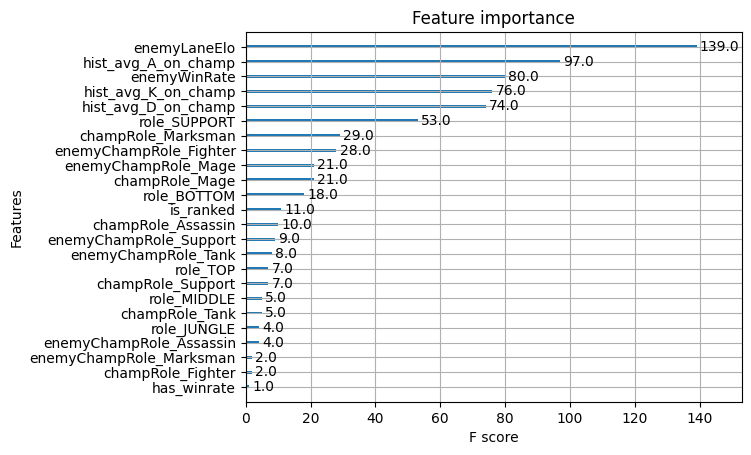

In [135]:
xgb.plot_importance(kills_xgb)
plt.show()


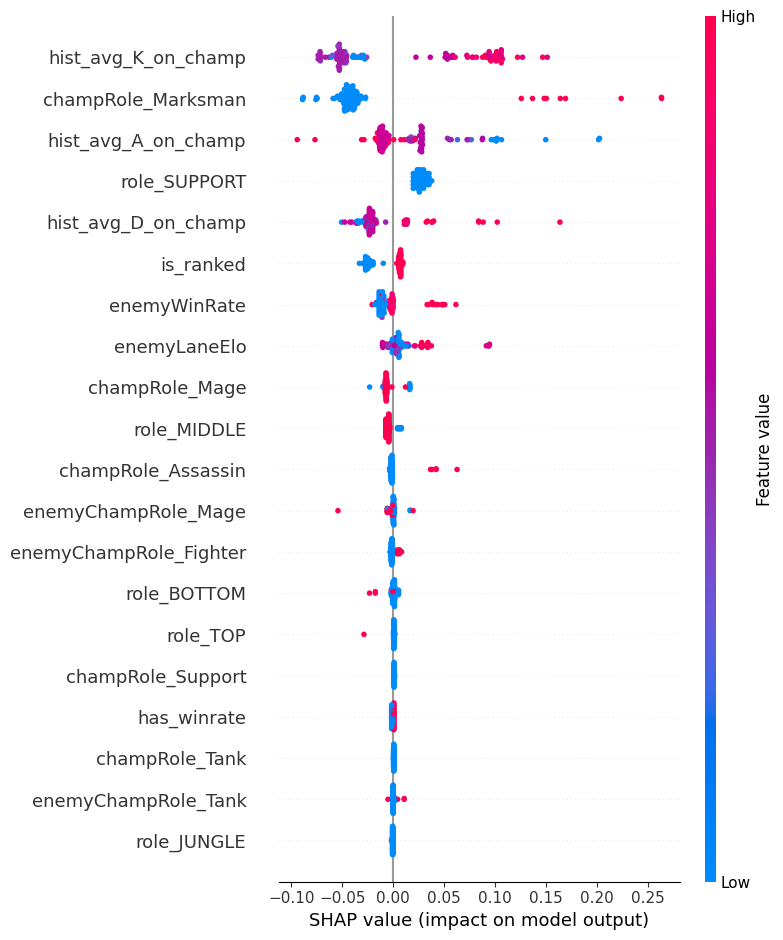

In [137]:
import shap
explainer = shap.TreeExplainer(kills_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


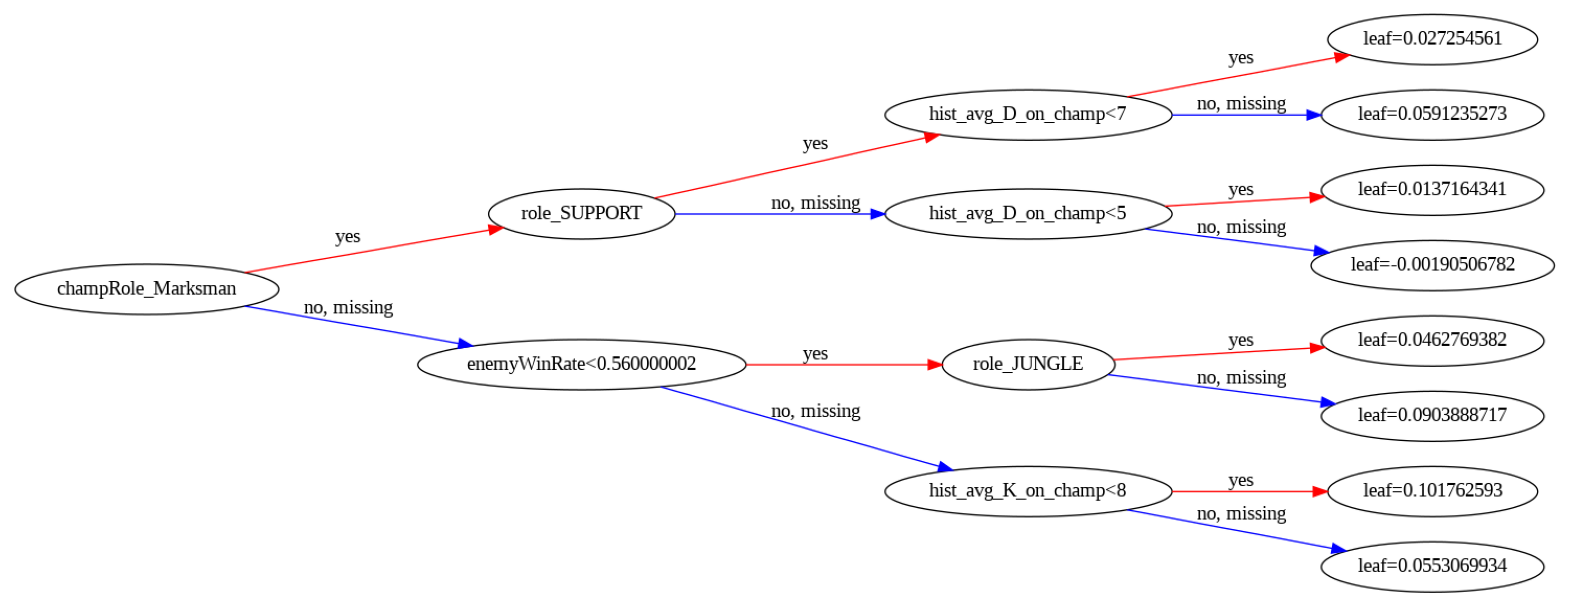

In [143]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(kills_xgb, num_trees=0, rankdir='LR', ax=ax)
plt.show()


In [145]:
# Save the models
with open('kills_model.pkl', 'wb') as f:
    pickle.dump(kills_xgb, f)

with open('deaths_model.pkl', 'wb') as f:
    pickle.dump(deaths_xgb, f)

with open('assists_model.pkl', 'wb') as f:
    pickle.dump(assists_xgb, f)

# Load Modles
#with open('kills_model.pkl', 'rb') as f:
#    loaded_kills_model = pickle.load(f)

#with open('deaths_model.pkl', 'rb') as f:
#    loaded_deaths_model = pickle.load(f)

#with open('assists_model.pkl', 'rb') as f:
#    loaded_assists_model = pickle.load(f)
